In [1]:
" No DWT cleaning applied "
# The jupyter script is used to carry out the analysis of the single run
# this is an ETL process: extract (from database), transform (preprocessing techniques), load (numPy arrays)
# from the music therapy study using a 12 seconds sliding window
# dataset is resampled due to undersampling during the recording
# ICA, notch and bandpass filtering are implmeneted to mitigate eeg noise
# results: spectogram and average bandpower comparison betwen timepoints per channel per brainwave

' No DWT cleaning applied '

In [2]:
from helper import*
from params import*

In [3]:
# SQL parameters
tableName_1 = 'MH_09_ES1_task1'
tableName_2 = 'MH_09_ES2_task1'
task = "Task 1"
query_1 = ("% s % s"%('SELECT * FROM', tableName_1))
query_2 = ("% s % s"%('SELECT * FROM', tableName_2))

In [4]:
# establish connection with music_therapy_eeg database
db_connection = create_db_connection(hostName,userName,userPassword,databaseName)
data_1 = df_to_table_query(db_connection,query_1)
data_2 = df_to_table_query(db_connection,query_2)

MySQL Database connection successful
Query successful
Query successful


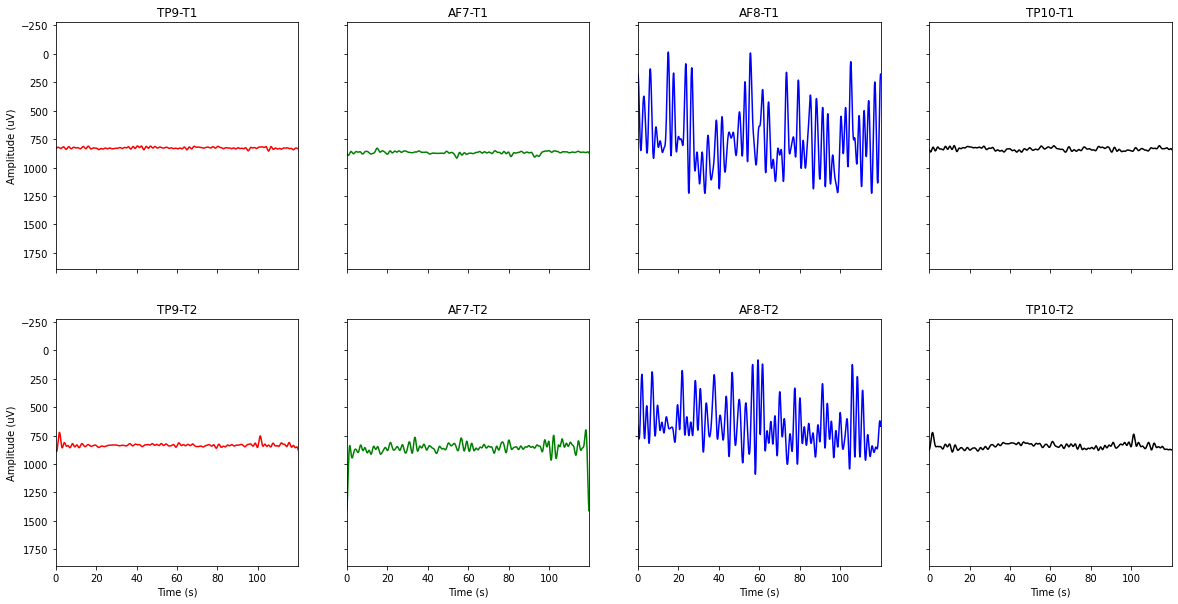

In [5]:
# transform sql extracted table to raw eeg data
rawEEG_1 = (singleTransformToRawEEG(data_1,fs,collection_time,fs_setting))[0]
rawEEG_2 = (singleTransformToRawEEG(data_2,fs,collection_time,fs_setting))[0]
time_s = (singleTransformToRawEEG(data_1,fs,collection_time,fs_setting))[1]
plots(time_s,(np.hstack((rawEEG_1,rawEEG_2))),['TP9-T1','AF7-T1','AF8-T1','TP10-T1','TP9-T2','AF7-T2','AF8-T2','TP10-T2'],(20,10),['r','g','b','k','r','g','b','k'])

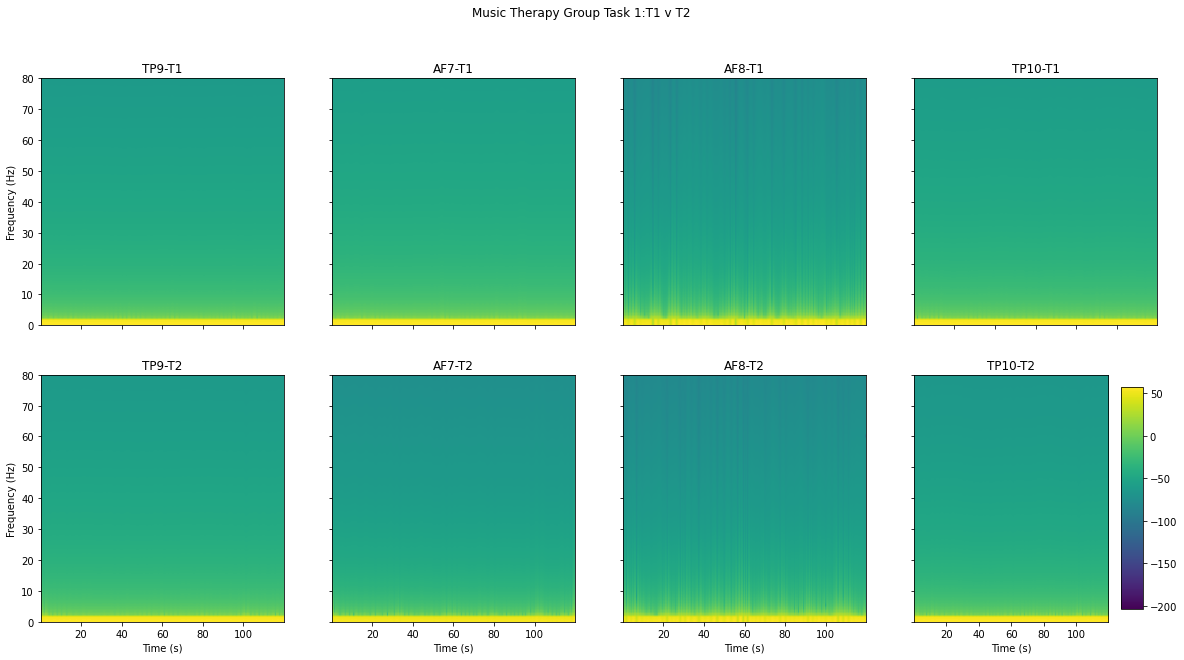

In [6]:
filtering = filters()
noc=filters()
notch_data_1 = noc.notch(rawEEG_1,line,fs,Q)
notch_data_2 = noc.notch(rawEEG_2,line,fs,Q)
spectogramPlot((np.hstack((notch_data_1,notch_data_2))),fs,nfft,noverlap,(20,10),['TP9-T1','AF7-T1','AF8-T1','TP10-T1','TP9-T2','AF7-T2','AF8-T2','TP10-T2'],'Music Therapy Group'+' '+task+':'+'T1 v T2')

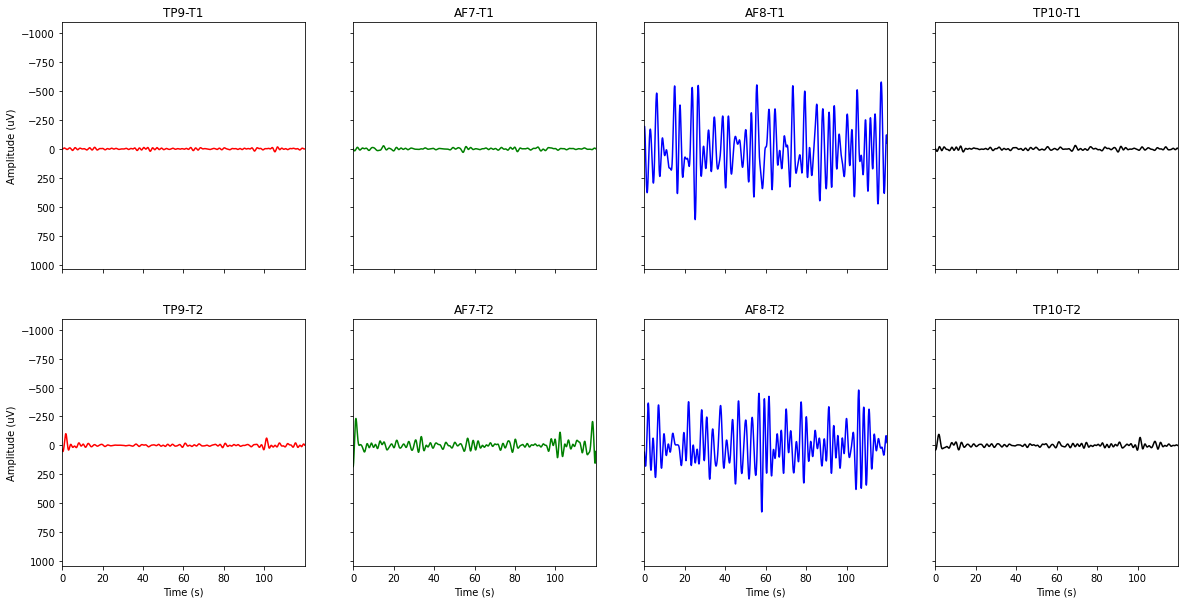

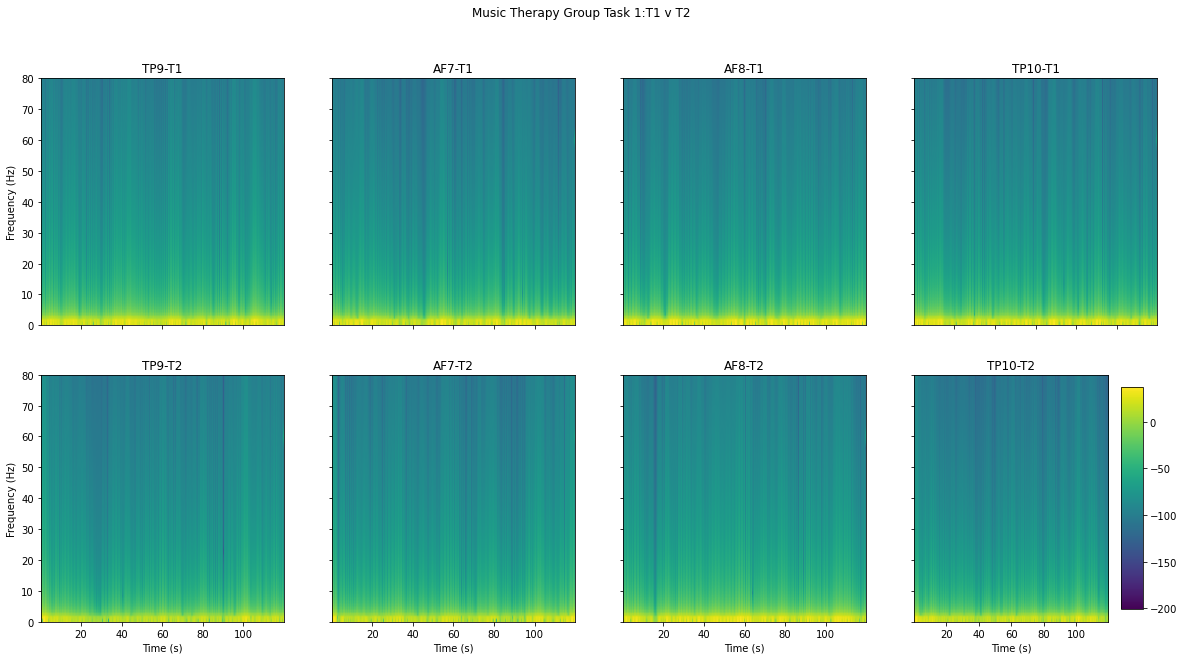

In [7]:
bpData_1 = filtering.butterBandPass(notch_data_1,lowcut,highcut,fs,order)
bpData_2 = filtering.butterBandPass(notch_data_2,lowcut,highcut,fs,order)
plots(time_s,(np.hstack((bpData_1,bpData_2))),['TP9-T1','AF7-T1','AF8-T1','TP10-T1','TP9-T2','AF7-T2','AF8-T2','TP10-T2'],(20,10),['r','g','b','k','r','g','b','k'])
spectogramPlot((np.hstack((bpData_1,bpData_2))),fs,nfft,noverlap,(20,10),['TP9-T1','AF7-T1','AF8-T1','TP10-T1','TP9-T2','AF7-T2','AF8-T2','TP10-T2'],'Music Therapy Group'+' '+task+':'+'T1 v T2')

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


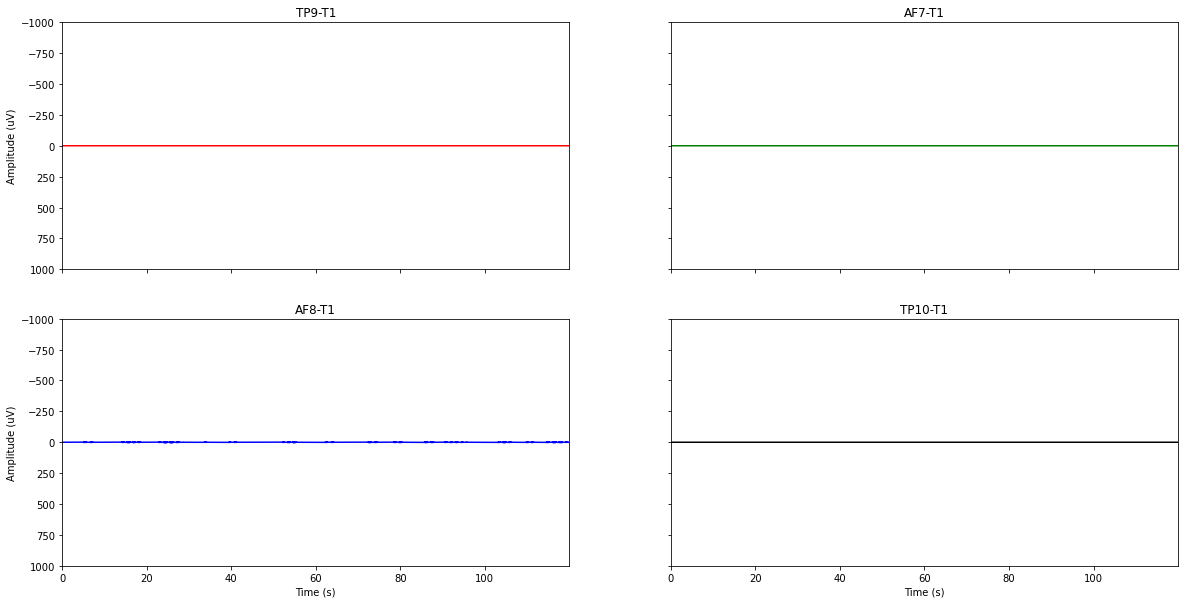

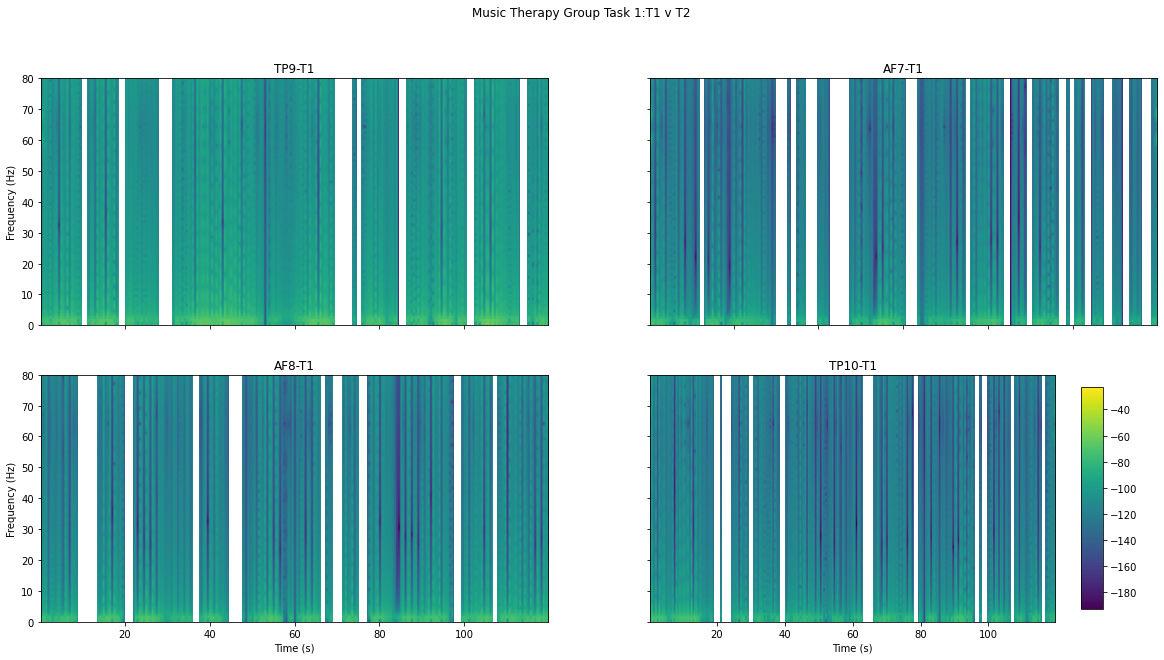

In [34]:
def dwtTest(data,wavelet):
    import pywt
    (ca_1, cd_1) = pywt.dwt(data[:,0],wavelet)
    (ca_2, cd_2) = pywt.dwt(data[:,1],wavelet)
    (ca_3, cd_3) = pywt.dwt(data[:,2],wavelet)
    (ca_4, cd_4) = pywt.dwt(data[:,3],wavelet)
    cat_1 = pywt.threshold(ca_1, np.std(ca_1)/2, mode='soft')
    cat_2 = pywt.threshold(ca_2, np.std(ca_2)/2, mode='soft')
    cat_3 = pywt.threshold(ca_3, np.std(ca_3)/2, mode='soft')
    cat_4 = pywt.threshold(ca_4, np.std(ca_4)/2, mode='soft')
    cdt_1 = pywt.threshold(cd_1, np.std(cd_1)/2, mode='soft')
    cdt_2 = pywt.threshold(cd_2, np.std(cd_2)/2, mode='soft')
    cdt_3 = pywt.threshold(cd_3, np.std(cd_3)/2, mode='soft')
    cdt_4 = pywt.threshold(cd_4, np.std(cd_4)/2, mode='soft')
    data_1 = pywt.idwt(np.zeros(len(cat_1)), cdt_1, wavelet)
    data_2 = pywt.idwt(np.zeros(len(cat_2)), cdt_2, wavelet)
    data_3 = pywt.idwt(np.zeros(len(cat_3)), cdt_3, wavelet)
    data_4 = pywt.idwt(np.zeros(len(cat_4)), cdt_4, wavelet)
    return (np.vstack((data_1,data_2,data_3,data_4)).T)

test_1 = dwtTest(bpData_1,'haar')
plots(time_s,test_1,['TP9-T1','AF7-T1','AF8-T1','TP10-T1'],(20,10),['r','g','b','k'])
spectogramPlot(test_1,fs,nfft,noverlap,(20,10),['TP9-T1','AF7-T1','AF8-T1','TP10-T1'],'Music Therapy Group'+' '+task+':'+'T1 v T2')



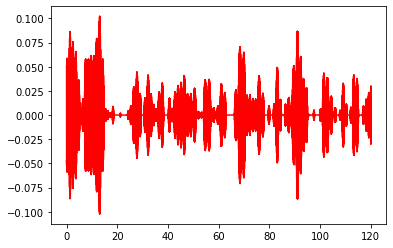

In [33]:
plt.plot(time_s,test_1[:,3],color='r')
plt.show()

In [9]:
# run sliding window on bandpass filtered data
rw_data_1 = rollingWindow(bpData_1,window_size,step_size)
rw_data_2 = rollingWindow(bpData_2,window_size,step_size)

In [10]:
# compute power spectrum of each window per channel
delta_low = brainwaves['delta'][0]
delta_high = brainwaves['delta'][1]
theta_low = brainwaves['theta'][0]
theta_high = brainwaves['theta'][1]
alpha_low = brainwaves['alpha'][0]
alpha_high = brainwaves['alpha'][1]
beta_low = brainwaves['beta'][0]
beta_high = brainwaves['beta'][1]
gamma_low = brainwaves['gamma'][0]
gamma_high = brainwaves['gamma'][1]

# compute average band power for timepoint 1
deltaAvgBandPower_1 = averageBandPower(rw_data_1,'3D',fs,delta_low,delta_high,win)
thetaAvgBandPower_1 = averageBandPower(rw_data_1,'3D',fs,theta_low,theta_high,win)
alphaAvgBandPower_1 = averageBandPower(rw_data_1,'3D',fs,alpha_low,alpha_high,win)
betaAvgBandPower_1 = averageBandPower(rw_data_1,'3D',fs,beta_low,beta_high,win)
gammaAvgBandPower_1 = averageBandPower(rw_data_1,'3D',fs,gamma_low,gamma_high,win)

# compute average band power for timepoint 2
deltaAvgBandPower_2 = averageBandPower(rw_data_2,'3D',fs,delta_low,delta_high,win)
thetaAvgBandPower_2 = averageBandPower(rw_data_2,'3D',fs,theta_low,theta_high,win)
alphaAvgBandPower_2 = averageBandPower(rw_data_2,'3D',fs,alpha_low,alpha_high,win)
betaAvgBandPower_2 = averageBandPower(rw_data_2,'3D',fs,beta_low,beta_high,win)
gammaAvgBandPower_2 = averageBandPower(rw_data_2,'3D',fs,gamma_low,gamma_high,win)

In [11]:
data_pre = np.vstack((deltaAvgBandPower_1,thetaAvgBandPower_1,alphaAvgBandPower_1,betaAvgBandPower_1,gammaAvgBandPower_1))
data_post = np.vstack((deltaAvgBandPower_2,thetaAvgBandPower_2,alphaAvgBandPower_2,betaAvgBandPower_2,gammaAvgBandPower_2))
                    
data_pre = np.hstack((data_pre[:,0],data_pre[:,1],data_pre[:,2],data_pre[:,3]))
data_post = np.hstack((data_post[:,0],data_post[:,1],data_post[:,2],data_post[:,3]))
diff = data_pre - data_post
test = normalityTest(diff)

....Executing Shapiro Wilks Test.......... 

Shapiro Wilks Test: data is not normally distributed, P-Value= 0.0

....confirming Shapiro Wilks Test non-normality result with D’Agostino’s K^2 test.......

Executing D’Agostino’s K^2 Test...
D’Agostino’s K^2 Test: data is not normally distributed, P-Value= 0.0

....confirming D’Agostino’s K^2 Test non-normality result with Anderson-Darling Test.......

Executing Anderson-Darling Test...
Statistic: 658.655
15.000: 0.575, Anderson-Darling Test: data is not normally distributed
10.000: 0.655, Anderson-Darling Test: data is not normally distributed
5.000: 0.785, Anderson-Darling Test: data is not normally distributed
2.500: 0.916, Anderson-Darling Test: data is not normally distributed
1.000: 1.090, Anderson-Darling Test: data is not normally distributed

 Wilcoxon Signed Test utilized to evaluate significance of data
